Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [1]:
from beanmachine.ppl.experimental.tests.vi.neals_funnel import NealsFunnel
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

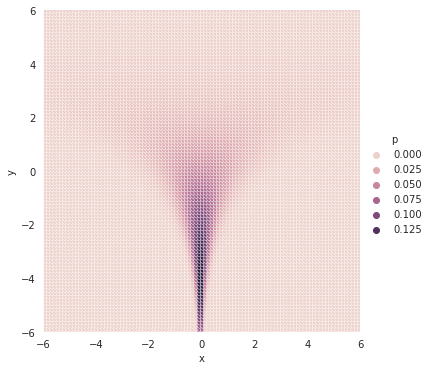

In [2]:
import torch

import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Draw some samples from Neal's funnel and plot a KDE

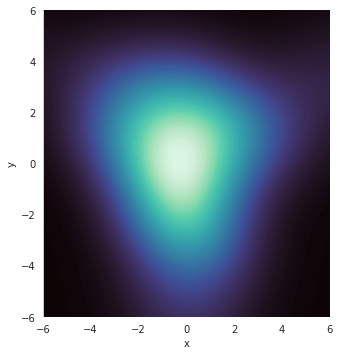

In [3]:
nf_samples = nf.sample(sample_shape=(100,2)).squeeze().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

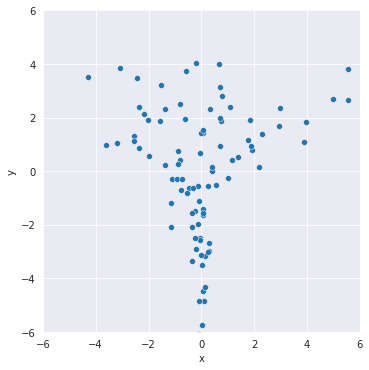

In [4]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Perform IAF Variational Approximation

In [5]:
import torch.distributions as dist

from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalApproximation

vi = VariationalApproximation(
    target_log_prob=nf.log_prob,
    base_dist=dist.MultivariateNormal(torch.zeros(2), torch.eye(2)))
vi.train(epochs=1000)

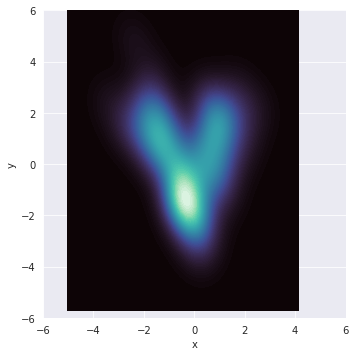

In [6]:
vi_samples = vi.sample((100,)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

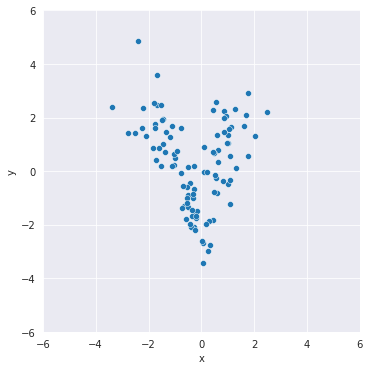

In [7]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

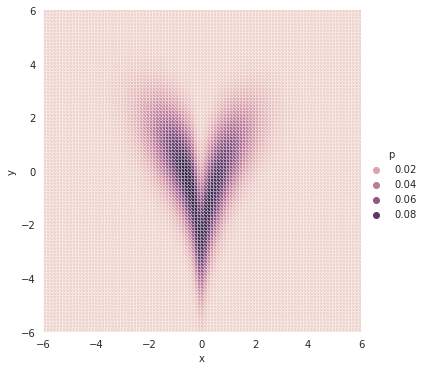

In [8]:
xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

In [9]:
import scipy.stats

print(
    scipy.stats.ks_2samp(nf_samples[:,0], vi_samples[:,0]).pvalue,
    scipy.stats.ks_2samp(nf_samples[:,1], vi_samples[:,1]).pvalue,
)

0.21117008625127576 0.1548386665118475


## Do the same for GMM

In [10]:
import torch.distributions as dist

def gmm(x):
    return torch.log(
        0.5*torch.exp(dist.MultivariateNormal(torch.tensor([-2,-1]), 0.5*torch.eye(2)).log_prob(x)) 
        + 0.5*torch.exp(dist.MultivariateNormal(torch.tensor([1,2]), 0.5*torch.eye(2)).log_prob(x)))

vi = VariationalApproximation(
    target_log_prob=gmm,
    base_dist=dist.MultivariateNormal(torch.zeros(2), torch.eye(2)))
vi.train(epochs=100, lr=1e-2)

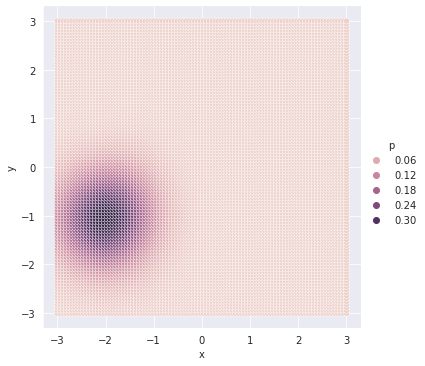

In [11]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

Compare against ground truth

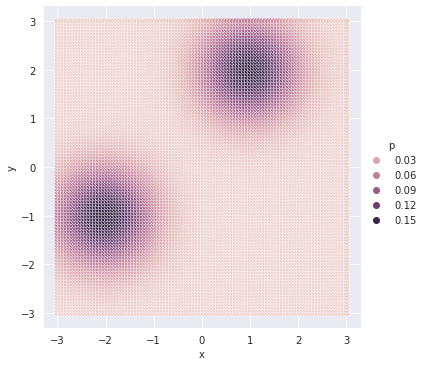

In [12]:
xs = torch.linspace(-3, 3)
ys = torch.linspace(-3, 3)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = gmm(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")

# Investigate heavy-tailed base distribution

In [13]:
target = dist.StudentT(df=1)

vi_normal = VariationalApproximation(
    target_log_prob=target.log_prob,
    base_dist=dist.Normal(0, 1))
vi_normal.train(epochs=500, lr=1e-3)

vi_student = VariationalApproximation(
    target_log_prob=target.log_prob,
    base_dist=dist.StudentT(df=1))
vi_student.train(epochs=500, lr=1e-3)

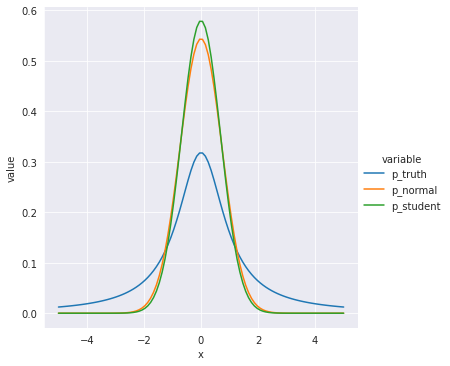

In [14]:
x = torch.linspace(-5, 5).unsqueeze(1)
p_truth = torch.exp(dist.StudentT(df=1).log_prob(x))
p_normal = torch.exp(vi_normal.log_prob(x))
p_student = torch.exp(vi_student.log_prob(x))
sns.relplot(data=pd.DataFrame({
    "x": x.flatten().detach().numpy(),
    "p_truth": p_truth.flatten().detach().numpy(),
    "p_normal": p_normal.flatten().detach().numpy(),
    "p_student": p_student.flatten().detach().numpy(),
}).melt(id_vars=["x"]), x="x", y="value", hue="variable", kind="line")